# Übung 7

**Gruppenname:**

*TLJ*

Christian Rene Thelen, Artur Less, Karl Johannes

### 7.1 Zulassungskommission (Logistische Regression, Gradientenabstieg)
Eine Kommission an einer Hochschule hat in den vergangenen Jahren Bachelorabsolventen, die sich für einen Masterstudiengang bewarben, nach eingehender Prüfung zugelassen oder abgelehnt. Die Hochschulverwaltung überlegt, die durch die Kommissionsarbeit gebundenen Arbeitsressourcen freizusetzen und die Kommission von ihrer Arbeit zu entbinden. Die Wahrscheinlichkeit, mit der die Kommission die Zulassung zum Masterstudium für eine Bewerberin / einen Bewerber empfohlen hätte, soll mithilfe von Machine Learning und historischer Daten (nämlich dem Punkteergebnis von zwei Klausuren jedes Bewerbers sowie die damalige Entscheidung der Kommission) vorhergesagt werden.

**Daten:**

Die Daten enthalten die Punktzahlen zweier Abschlussklausuren (Feature 1 und Feature 2), die ein Bewerber / eine Bewerberin in ihrem Bachelorstudium erzielte, sowie die Entscheidung (Label) der Kommission, ob der Bewerber zum Masterstudium zugelassen wurde (+1) oder abgelehnt wurde (0). Und bevor Sie fragen: Dies ist ein ausgedachter Fall und kein Fall der FH Aachen.

**Ihre Aufgaben**

(1) Importieren Sie die Daten. Ich habe Ihnen in der ersten Spalte der Datenmatrix $X$ bereits Einsen eingetragen, damit Sie dies nicht mehr selbst implementieren müssen. Die Features (Feature 1 und 2) befinden sich in der zweiten und dritten Spalte der Matrix $X$. Das Label ($y$) habe ich Ihnen in der unteren Code-Zelle bereits so konvertiert, dass sie die Werte $-1$ bzw. $+1$ annimmt. Tragen Sie in einem Scatterplot Feature 1 gegen Feature 2 auf. Markieren Sie über Farbe oder Symbole, ob die Studienanwärter zum Masterstudium zugelassen wurden ($y=1$) oder nicht ($y=-1$).

In [172]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Sie finden diese Daten auch zum Download unter: https://data.bialonski.de/ml/admission-data.txt
data = np.loadtxt('https://data.bialonski.de/ml/admission-data.txt', delimiter=',')

# Ihre Daten:
X, y = np.insert(data[:, :2] / 100, 0, 1, 1), (data[:, 2] - .5) * 2

Text(0, 0.5, 'Zweite Abschlussprüfung')

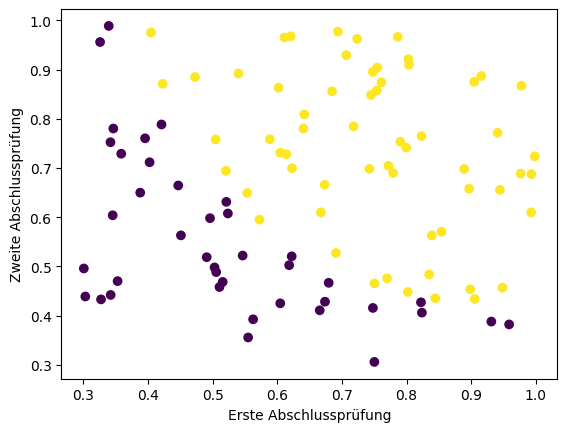

In [173]:
plt.scatter(X[:, 1], X[:, 2], c=y)
plt.xlabel("Erste Abschlussprüfung")
plt.ylabel("Zweite Abschlussprüfung")

(2) Implementieren Sie eine Funktion `gradient`, die einen Gewichtsvektor, Features und Labels entgegennimmt und den Gradientenvektor der logistischen Regression zurückgibt. Schlagen Sie in den entsprechenden Folien der Vorlesung nach. Erinnern Sie sich daran, dass jeder Feature-Vektor drei Komponenten ($x_0$, $x_1$, $x_2$) hat, wobei $x_0=1$ und $x_1$ sowie $x_2$ der Wert des ersten bzw. zweiten Features ist.

$$
	\nabla E_\text{in}(w(t)) = - \frac{1}{N} \sum^{N}_{n=1} (y_n x_n)\, \theta(-y_n w^Tx_n)
	\quad\text{mit}\quad\theta(s)=\frac{1}{1+\text{e}^{-s}}
$$

In [174]:
def theta(s):
    return 1 / (1 + np.exp(-s))

def gradient(w, X, y):
    """Gibt den Gradientenvektor der logistischen Regression zurück"""
    N = X.shape[0]
    sigma = 0
    for n in range(N):
        sigma += (y[n] * X[n]) * theta(-y[n] * np.dot(w.T, X[n]))
    sigma *= -1/N
    return np.array(sigma).reshape(X.shape[1], 1)

gradient(np.zeros((X.shape[1], 1)), X, y)

array([[-0.1       ],
       [-0.12009217],
       [-0.11262842]])

(3) Implementieren Sie eine Funktion `E_in`, die einen Gewichtsvektor $\mathbf{w}$, die Featurevektoren $\mathbf{x}$ sowie die Labels $\mathbf{y}$ entgegennimmt und Ihnen den Fehler $E_\text{in}(\mathbf{w})$ der logistischen Regression zurückgibt.

Der Fehler der logistischen Regression ist
$$
    E_\text{in}(w) = \frac{1}{N}\sum^N_{n=1} \ln\left( 1+ \exp(-y_n\cdot w^T x_n) \right)
$$

In [175]:
def E_in(w, x, y) -> float:
    """Gibt den In-Sample-Fehler E_in(w) der logistischen Regression zurück

    Args:
        w (np.ndarray): Gewichtsvektor (M, 1)
        x (np.ndarray): Featurevektorn (N, M)
        y (np.ndarray): Labels zum Testen (N, )

    Returns:
        float: In-Sample-Fehler der logistischen Regression
    """
    assert w.shape == (x.shape[1], 1), "Gewichtsvektor (M, 1) muss zu Featurmatirx (N, M) passen."
    assert x.shape[0] == y.shape[0], "Es müssen genauso viele Testlabels y wie Datenpunkte x übergeben werden."
    N = x.shape[0]
    sigma: float = 0
    for n in range(N):
        sigma += np.log(1 + np.exp(-y[n] * np.dot(w.T, x[n])))
    sigma *= 1/N
    return sigma

E_in(np.zeros((X.shape[1], 1)), X, y)

array([0.69314718])

(4) Implementieren Sie den "Gradientenabstieg mit fixierter Lernrate" (Funktion `grad_descent`), wie Sie ihn in der Vorlesung kennengelernt haben. Vergegenwärtigen Sie sich, dass beim Gradientenabstieg die Gewichtsvektoren verändert werden, nicht aber die Daten ($\mathbf{x}$ und $\mathbf{y}$ bleiben unverändert). Bauen Sie zusätzlich ein, dass bei jedem Iterationsschritt $t$ der Fehler $E_\text{in}(\mathbf{w}(t))$ berechnet wird und am Ende - neben dem finalen Gewichtsvektor - auch sämtliche über die Iterationen hinweg erzielten Fehler als Vektor herausgegeben wird.

In [176]:
def grad_descent(w: np.ndarray, X: np.ndarray, y: np.ndarray, eta: float, T: int) -> tuple[np.ndarray, np.ndarray]:
    """Führt einen Gradientenabstieg mit fixierter Lernrate durch errechnet nach jeder Iteration den In-Sample-Fehler und gibt den finalen Gewichtsvektor w(t) sowie den Vektor mit den Fehlern zurück.

    Args:
        w (np.ndarray): Initialer Gewichtsvektor. Kann bspw. mit w(0)=0 oder mit Standardnormalverteilen Werten initialisiert werdne.
        X (np.ndarray): Daten
        y (np.ndarray): Labels
        eta (float): Lernrate bspw. 0.001, 0.01, 0.1, 0.5, 1 
        T (int): Anzahl der Iterationen (Terminationskriterium) bspw. 400

    Returns:
        tuple[np.ndarray, np.ndarray]: Finalen Gewichtsvektor, Array mit In-Sample-Fehlern
    """
    w_t = w
    E_in_list = []
    for t in range(T):
        # Berechne den Gradienten
        g_t = gradient(w_t, X, y)
        # Setze die Richtung
        v_t = - g_t
        # Führe Gewichtsupdate durch
        w_next = w_t + eta * v_t
        # Speichere E_in für den aktuellen Gewichtsvektor in einer Liste
        E_in_list.append(E_in(w_next, X, y))
        if all(w_next == w_t):
            w_t = w_next
        w_t = w_next

    return w_t, np.array(E_in_list)

(5) Entscheiden Sie sich dafür, wie sie den Anfangsgewichtsvektor $\mathbf{w}(0)$ initialisieren wollen. Sie können beispielsweise die Komponenten von $\mathbf{w}(0)$ aus einer Standardnormalverteilung mit kleiner Varianz ziehen. Oder Sie können einmal ausprobieren, $\mathbf{w}(0) = \mathbf{0}$ zu setzen.

In [177]:
w_init = np.random.standard_normal(size=(X.shape[1], 1))
w_init = np.zeros((X.shape[1], 1))

(6) Entscheiden Sie sich für Terminationskriterien und eine Lernrate $\eta$ für den Gradientenabstieg. Ausgangspunkt könnte beispielsweise eine Lernrate von $\eta = 0.1$ und einer Termination bei 400 Iterationen sein. Sie können hier aber gerne experimentieren und herausfinden, ob Sie bessere Werte und Kriterien für das vorliegende Lernproblem finden.

In [178]:
w_final, E_in_list = grad_descent(w_init, X, y, eta=0.1, T=2000)
print(w_final)

[[-4.43649977]
 [ 4.1112139 ]
 [ 3.4975671 ]]


(7) Führen Sie einen Gradientenabstieg durch und visualisieren Sie den Fehler $E_\text{in}(t)$ über die Iterationsschritte $t$ hinweg. 

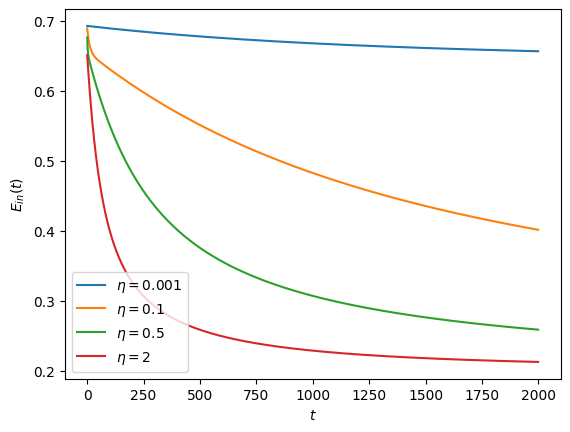

In [179]:
T = 2000
w_final, E_in_list_1 = grad_descent(w_init, X, y, eta=0.001, T=T)
w_final, E_in_list_2 = grad_descent(w_init, X, y, eta=0.1, T=T)
w_final, E_in_list_3 = grad_descent(w_init, X, y, eta=0.5, T=T)
w_final, E_in_list_4 = grad_descent(w_init, X, y, eta=2, T=T)

plt.plot(np.arange(T), E_in_list_1, label="$\\eta = 0.001$")
plt.plot(np.arange(T), E_in_list_2, label="$\\eta = 0.1$")
plt.plot(np.arange(T), E_in_list_3, label="$\\eta = 0.5$")
plt.plot(np.arange(T), E_in_list_4, label="$\\eta = 2$")
plt.ylabel("$E_{in} (t)$")
plt.xlabel("$t$")
plt.legend()
plt.show()

(8) Nutzen Sie das finale Modell $g$ (spezifiziert durch den finalen Gewichtsvektor), um die Zulassungswahrscheinlichkeit $\left( g(\mathbf{x}) = \mathbb{P}[y=+1|\mathbf{x}] \right)$ für das Masterstudium eines Anwärters vorherzusagen, der folgende Ergebnisse in seinen zwei Abschlussklausuren erzielte: (Feature 1, Feature 2) = (0.45, 0.85). Schlagen Sie dazu in den Folien der Vorlesung nach, wie diese Wahrscheinlichkeit aus dem Gewichtsvektor und dem Featurevektor zu berechnen ist.

$$
    P(y|x) = h(y\cdot x) = \theta(y\cdot w^Tx)\quad \text{mit}\quad \theta(s)=\frac{1}{1+\text{e}^{-s}}
$$

In [180]:
def probability(w, x, y):
    assert x.shape[1] == y.shape[0], "Es müssen so viele Labels wie Features übergeben werden"
    s = np.multiply(y, np.dot(w.T, x))
    return theta(s)[0]

# Initialisiere den Anfangsgewichtsvektor w(0) mit einer Standardnormalverteilung mit kleiner Varianz, statt mit w(0) = 0
w_init = np.random.standard_normal(size=(X.shape[1], 1))
w_init = np.zeros((X.shape[1], 1))

w_final, _ = grad_descent(w_init, X, y, eta=0.1, T=2000)

# Zulassungswahrscheinlichkeit (y_test = 1) für den folgenden Anwärter für das Masterstudium
X_test = np.array([[1, 1, 1, 1], [0.45, 0.33, 0.9, 0.5], [0.85, 0.32, 0.5, 0.5]])
y_test = np.array([1, 1, 1, 1])

print(probability(w_final, X_test, y_test))

print('Die Wahrscheinlichkeit für eine Zulassung beträgt {:5.4f}%\n'.format(
    probability(w_final, X_test, y_test)[0] * 100)
)

[0.59543469 0.12340454 0.73348494 0.34703242]
Die Wahrscheinlichkeit für eine Zulassung beträgt 59.5435%



(9) Visualisieren Sie die Zulassungswahrscheinlichkeit für die Featureebene, die durch Feature 1 und 2 aufgespannt wird: Legen Sie dazu ein Grid durch den Feature-Raum, wobei Sie jedes der beiden Feature von $0$ bis $1$ in $0.01$-er Schritten scannen, für jedes Wertepaar die 
Zulassungswahrscheinlichkeit berechnen, und im Anschluss daran visualisieren. `plt.imshow` kann Ihnen dabei helfen.

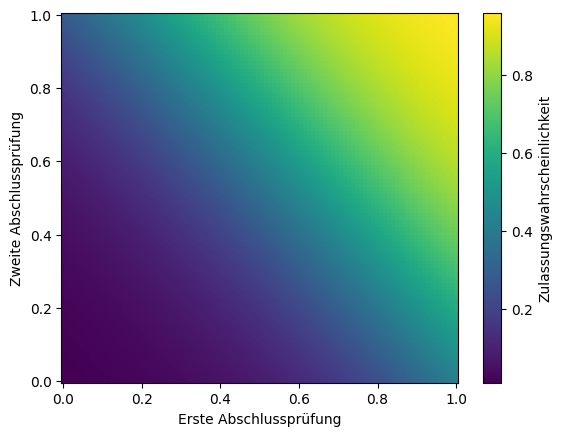

In [181]:
f = np.linspace(0, 1, 100)
F1, F2 = np.meshgrid(f, f)
inputs = np.stack([np.ones(F1.shape), F1, F2], axis=-1).reshape(-1, 3)

results = probability(w_final, inputs.T, np.array([1]*inputs.shape[0])).reshape(100, -1)

plt.pcolormesh(F1, F2, results)
plt.colorbar(label="Zulassungswahrscheinlichkeit")  # Farblegende
plt.xlabel("Erste Abschlussprüfung")
plt.ylabel("Zweite Abschlussprüfung")
plt.show()